In [172]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler#Keras
import keras
import tensorflow as tf


In [378]:
#defining data paths and neccessary variables
SAVED_MODEL_PATH = "model5_all_features.h5"
EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [18]:
df = pd.read_csv('Train.csv')
sample_sub = pd.read_csv('SampleSubmission.csv')
df.shape, sample_sub.shape

((1109, 2), (1017, 194))

In [10]:
#Creating a header for ourcsv file to store our data

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):  #its 1 to 21 because mfcc has 21 columns
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [11]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [12]:
for songname in df['fn']:
        
        y, sr = librosa.load(songname, mono=True)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{songname} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}' 
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [318]:
data = pd.read_csv('data.csv')

In [319]:
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,audio_files/IV38R7F.wav,0.449615,0.036331,2464.608280,2052.566381,4764.932193,0.163376,-475.988342,42.850571,-5.496119,...,-4.184888,1.200247,-7.129832,0.902059,0.068046,-1.860884,-1.458506,-0.831166,-1.691265,NaN
1,audio_files/KM4SKWT.wav,0.562000,0.194779,1300.411033,1977.379357,2522.873942,0.040713,-111.754181,137.786835,-5.629675,...,5.427469,2.849771,1.156728,0.149515,4.400822,-2.614339,3.924227,-3.614870,4.666934,NaN
2,audio_files/F5POSU9.wav,0.540322,0.281683,1943.406614,2289.002359,3914.955648,0.061447,-47.960114,97.102974,-16.262344,...,1.315997,-0.334233,7.317841,2.578547,8.096319,0.717559,6.615470,-1.229078,5.105130,NaN
3,audio_files/MMVDXG2.wav,0.320626,0.014163,2002.818447,1816.961550,4289.779721,0.135622,-453.759094,102.125031,-2.364913,...,-0.966605,-13.227746,5.627367,-9.027304,-6.209201,2.719011,-7.601274,-0.474875,-2.802763,NaN
4,audio_files/9TVM96F.wav,0.435339,0.041622,1621.551184,1413.281627,2976.422063,0.101683,-368.779999,119.367859,-41.034409,...,-10.228896,-3.070230,-13.005276,-6.210487,-0.560715,-7.880075,-5.454712,-1.018409,-5.983365,NaN


We’ve calculated all the features using librosa package and has created a dataset with the data.csv file name and has inserted all the feature values of given music in given headers.

In [320]:
#replacing the empty label column with the original label column in train.csv
data['label']=df['label']

## Preprocessing Dataset


In [321]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)


In [322]:
#Now we encode label column

label_list = data.iloc[:, -1] #selecting all rows in the last column(-1)
encoder = LabelEncoder()
y = encoder.fit_transform(label_list)
print(y)

[ 10  16 141 ...  87 129 139]


In [323]:
#Normalising the dataset
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) #selecting all rows in all columns except the last column(i.e -1)

#In this x is calculated by removing the mean and dividing by the variance.

## Model creating, training and testing
### Creating a Model

In [324]:
# # create train, validation, test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)
   
# # add an axis to nd array
# # X_train = X_train[..., np.newaxis]
# # X_test = X_test[..., np.newaxis]
# # X_validation = X_validation[..., np.newaxis]


In [379]:
def prepare_dataset(X,y, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.

    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation

    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

#     # add an axis to nd array
#     X_train = X_train[..., np.newaxis]
#     X_test = X_test[..., np.newaxis]
#     X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

    

In [380]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.

    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):

    :return model: TensorFlow model
    """
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(254, activation='relu', input_shape= input_shape), 
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(193, activation='softmax')])
    
    # define optimiser
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser, loss=loss, metrics=['accuracy'])

    # print model parameters on console
    model.summary()
    

    return model


In [381]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model

    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set

    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history


In [382]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()



Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 254)               6858      
_________________________________________________________________
dense_60 (Dense)             (None, 120)               30600     
_________________________________________________________________
dense_61 (Dense)             (None, 193)               23353     
Total params: 60,811
Trainable params: 60,811
Non-trainable params: 0
_________________________________________________________________
Train on 709 samples, validate on 178 samples
Epoch 1/10
709/709 [==============================] - 1s 2ms/sample - loss: 5.2732 - accuracy: 0.0085 - val_loss: 5.2817 - val_accuracy: 0.0000e+00
Epoch 2/10
709/709 [==============================] - 1s 734us/sample - loss: 5.1838 - accuracy: 0.0197 - val_loss: 5.2655 - val_accuracy: 0.0056
Epoch 3/10
709/709 [===================

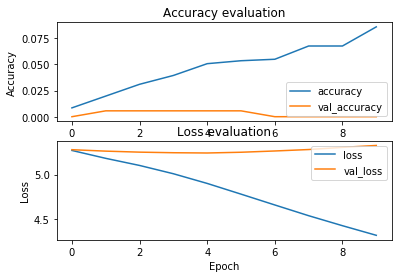

222/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [383]:
def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(X, y)

    # create network
    input_shape = (26,)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    model.save(SAVED_MODEL_PATH)


if __name__ == "__main__":
    main()


In [370]:
# import tensorflow as tf


# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(254, activation='relu', input_shape=(26,)), 
#     tf.keras.layers.Dense(120, activation='relu'),
#     tf.keras.layers.Dense(194, activation='softmax')])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# hist = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_validation, y_validation))


## PROCESING THE TEST SET

In [245]:
#Creating a header for ourcsv file to store our data

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):  #its 1 to 21 because mfcc has 21 columns
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [246]:
file = open('test_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [247]:
for songname in sample_sub['fn']:
        
        y, sr = librosa.load(songname, mono=True)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{songname} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}' 
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        file = open('test_data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [356]:
test_data = pd.read_csv('test_data.csv')
test_data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,audio_files/00118N3.wav,0.374535,0.054125,1892.489208,2330.542827,3776.706521,0.085660,-264.064209,115.357208,35.642284,...,2.177417,-7.710699,-9.355255,-10.159339,-4.187470,-9.133896,-7.352005,-12.253077,-1.595746,NaN
1,audio_files/00P0NMV.wav,0.463548,0.061802,2407.378278,1962.933392,4670.064214,0.163068,-361.880981,61.932018,-25.703701,...,-12.089739,-1.225272,-5.811265,-0.690165,-3.418268,-4.245774,-2.594992,-3.855736,-1.413907,NaN
2,audio_files/01QEEZI.wav,0.315547,0.049430,2058.896363,1576.299727,3424.693442,0.146756,-430.161682,79.694214,10.646952,...,-9.717668,4.265187,-8.468893,-2.142427,-6.465826,0.842213,-0.774048,1.728260,-0.274254,NaN
3,audio_files/037YAED.wav,0.473087,0.046160,3038.670423,1948.492782,4966.856759,0.244813,-472.820496,43.716751,0.029212,...,-5.924993,-1.932423,-3.049218,-4.720918,-4.062554,1.778725,-5.016870,-1.723710,-0.590242,NaN
4,audio_files/0382N0Y.wav,0.356902,0.036991,1896.187861,1836.684246,3919.042969,0.105754,-406.552704,97.861374,-8.950704,...,-11.119925,1.177802,-11.956388,4.176840,-0.422893,-1.527469,-9.776343,-7.352884,-0.174162,NaN


In [357]:
test_data.shape

(1017, 28)

In [358]:
# Dropping unneccesary columns
test_data = test_data.drop(['filename', 'label'],axis=1)

In [359]:
#Normalising the dataset
scaler = StandardScaler()
test_data = scaler.fit_transform(np.array(test_data.iloc[:, :], dtype = float)) #selecting all rows in all columns except the last column(i.e -1)

#In this scaled is calculated by removing the mean and dividing by the variance.

## LOADING MODEL, PREDICTING AND PREPARING SUBMISSION FILE

In [384]:
#loading model and predicting with  the model
model= tf.keras.models.load_model('model5_all_features.h5')

In [385]:
#predicting the test set proper
ssd = model.predict(test_data)

In [386]:
#copying sample_sub into a new variable
samp = sample_sub.copy()

#obtaining column list
wwe=samp.columns

#eliminating the fn column
wwe = wwe[1:]

# creating the dataframe 
df3 = pd.DataFrame(data = ssd,  
                  index = None,  
                  columns = wwe) 

#Adding back the fn column to submission file but first assigning it to a variable
tio = sample_sub['fn']

#now we combine all datasets together
cbd =pd.concat([tio,df3], axis=1)

cbd.to_csv('Sub6.csv', index=False)

## OBSERVATIONS
1. My first inference/submission was using only MFCCs(freq based) feature where i obtained an LB score of 7.27. But as soon as i included all other freq and time-based features as seen below it improved to a 5.2.

1. Noticed that the validation loss increases as the epochs increases

2. hence because of no.1, I reduced the epochs from 40(which gave me       6.2) to 10 epochs which gave me my highest score (5.2) so far on the leaderboard.

3. While I tried to increase the epochs from 40 to 400, i got a very low loss on the leaderboard i.e 13.5. Hence, increasing the epochs much is not reliable in this work as the data is very small

4. While I tried to use all the data X and y to train, I got a higher loss(5.3) than my lowest loss on LB(5.2).

5. I also tried to reduce the batch_size from 32 to 5 but got an even higher loss = 5.7 on the LB.

6. Note that for 3,4 and 5, the val_loss and train_loss were significantly reduced but the results didnt reflect on the public lb


7. the following are the parameters for my cuurent hight lb position:
    EPOCHS = 10
    BATCH_SIZE = 32
    PATIENCE = 5
    LEARNING_RATE = 0.0001
     
    
model = tf.keras.Sequential([
    tf.keras.layers.Dense(254, activation='relu', input_shape= input_shape), 
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(193, activation='softmax')])
    
    # define optimiser
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser, loss=loss, metrics=['accuracy'])


In [95]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=2)
# skf.get_n_splits(X, y)


# StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
# for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
